# SSM non parametrique 

## initial

In [1]:
def convertir_en_float(chaine):
    return float(chaine.replace(',', '.'))

In [94]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self,X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

Epoch 1/20
4/4 [==============================] - 1s 4ms/step - loss: 0.6979
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6977
Epoch 3/20
4/4 [==============================] - 0s 1ms/step - loss: 0.6975
Epoch 4/20
4/4 [==============================] - 0s 314us/step - loss: 0.6973
Epoch 5/20
4/4 [==============================] - 0s 2ms/step - loss: 0.6970
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6967
Epoch 7/20
4/4 [==============================] - 0s 1ms/step - loss: 0.6966
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.6963
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6961
Epoch 10/20
4/4 [==============================] - 0s 0s/step - loss: 0.6962
Epoch 11/20
4/4 [==============================] - 0s 0s/step - loss: 0.6962
Epoch 12/20
4/4 [==============================] - 0s 1ms/step - loss: 0.6962
Epoch 13/20
4/4 [==============================] - 0s 6ms/step - loss: 0.

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 4ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


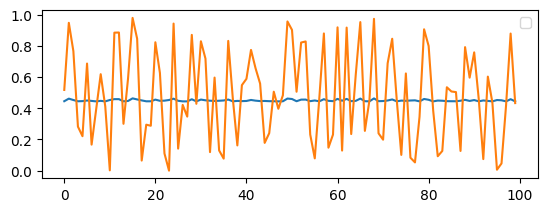

In [165]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy



# Generate some random data for testing
np.random.seed(23)
X_train = np.random.rand(100, 1) # Example data with 100 samples and 1 feature
y_train = np.append(X_train[1:], np.random.rand(1, 1))  # Example labels
X_test = np.random.rand(100, 1)
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(X_train)
rbf_layer = RBFLayer(output_dim=1, initializer=rbf_initializer, betas=1.0, input_shape=(1,))

# Build a simple model
model = Sequential()
model.add(rbf_layer)
model.add(Dense(1,activation='sigmoid', name='foo'))

# Compile the model
model.compile(optimizer='rmsprop', loss=binary_crossentropy)

# Train the model
a=model.fit(X_train, y_train, epochs=20, batch_size=32)

# Optionally, you can save the model for later use
model.save('rbf_model.h5')
pred = model.predict(X_train)
plt.subplot(2,1,2)
plt.plot(pred)
plt.plot(X_train)
plt.legend()

32/32 [==============================] - 1s 3ms/step - loss: 1.7839 - output_1_loss: 1.1147 - output_2_loss: 0.6692


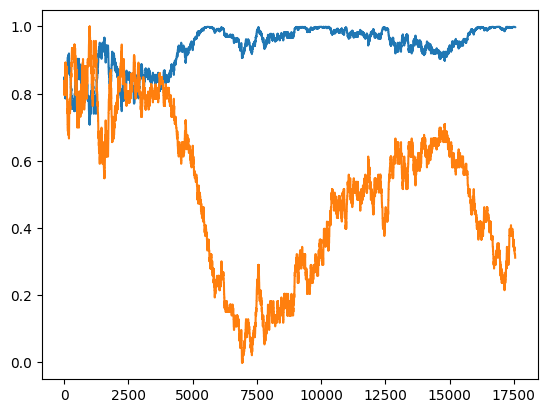

In [166]:

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# State Space Model with RBFLayer as volatility factor
class StateSpaceModel(tf.keras.Model):
    def __init__(self, rbf_output_dim, observation_dim, **kwargs):
        super(StateSpaceModel, self).__init__(**kwargs)
        self.rbf_layer = RBFLayer(output_dim=rbf_output_dim, input_shape=(1,))
        self.dense_layer = Dense(units=observation_dim)

    def call(self, inputs):
        volatility = self.rbf_layer(inputs)
        observation = self.dense_layer(volatility)
        return observation, volatility

# Example usage
np.random.seed(23)
scaler = MinMaxScaler()
df= pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep =";")
xk_data =  scaler.fit_transform(df.price.apply(convertir_en_float).values.reshape(-1, 1))
x_train = xk_data[0:1000]
y_train = xk_data[1:1001]
x_test = xk_data[1001:]
observation_dim = 1
rbf_output_dim = 10

model = StateSpaceModel(rbf_output_dim, observation_dim)
model.compile(optimizer='adam', loss='mse')
model.fit(x_train,np.zeros(1000))
[obs,vol] = model(x_test)
plt.plot(obs)
plt.plot(x_test)



# Avec exemple du git

32/32 [==============================] - 0s 2ms/step


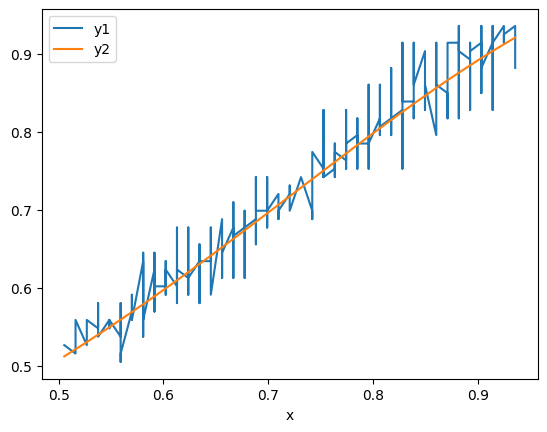

MSE: 0.0004


In [167]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MSE

import matplotlib.pyplot as plt

df= pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep =";")
xk_data =  scaler.fit_transform(df.price.apply(convertir_en_float).values.reshape(-1, 1))
x_train = xk_data[0:1000]
y_train = xk_data[1:1001]
x_test = xk_data[1001:2001]
observation_dim = 1
rbf_output_dim = 10

initializer=InitCentersRandom(x_train)
# create RBF network as keras sequential model
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=initializer,
                    betas=2.0,
                    input_shape=(1,))
outputlayer = Dense(1, use_bias=False)

model.add(rbflayer)
model.add(outputlayer)

model.compile(loss='mean_squared_error',
                optimizer=RMSprop())

# fit and predict
model.fit(x_train, y_train,
            batch_size=50,
            epochs=200,
            verbose=0)

y_pred = model.predict(x_train)
df = pd.DataFrame({'x':x_train.squeeze(),'y1' :y_train.squeeze(),'y2':y_pred.squeeze()})
df = df.sort_values(by='x')
df=df.set_index('x')
df.plot()
      # response from data


# plot centers
centers = rbflayer.get_weights()[0]
widths = rbflayer.get_weights()[1]
#plt.scatter(centers, np.zeros(len(centers)), s=20*widths)

plt.show()

# calculate and print MSE
print(f"MSE: {MSE(y_train.squeeze(), y_pred.squeeze()):.4f}")

   

## autres

Epoch 1/10
16/16 [==============================] - 1s 2ms/step - loss: 0.1455
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0796
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 6/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 10/10
  1/549 [..............................] - ETA: 37s

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


549/549 [==============================] - 1s 1ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


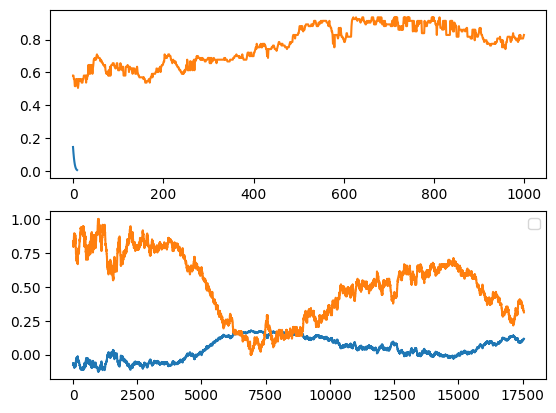

In [162]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
df= pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep =";")
xk_data =  scaler.fit_transform(df.price.apply(convertir_en_float).values.reshape(-1, 1))
x_train = xk_data[0:1000]
y_train = xk_data[1:1001]
x_test = xk_data[1001:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)
rbf_layer = RBFLayer(output_dim=2, initializer=rbf_initializer, betas=1.0, input_shape=(1,))

# Build a simple model
model = Sequential()
model.add(rbf_layer)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(x_train, y_train, epochs=10, batch_size=64)

# Optionally, you can save the model for later use
model.save('rbf_model.h5')
pred = model.predict(x_test)

plt.subplot(2,1,1)
plt.plot(a.history['loss'])
plt.plot(x_train)
plt.subplot(2,1,2)
plt.plot(pred)
plt.plot(x_test)
plt.legend()

## Mise à jour

In [174]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

class InitCentersRandom(Initializer):
    def __init__(self, X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

class NonParametricDynamicSSM():
    def __init__(self, output_dim, state_dim, exog_dim, rbf_centers_initializer=None, betas=1.0):
        self.state_dim = state_dim
        self.exog_dim = exog_dim
        self.state_transition = RBFLayer(output_dim, initializer=rbf_centers_initializer, betas=betas)
        self.observation = RBFLayer(output_dim, initializer=rbf_centers_initializer, betas=betas)
        self.model = Sequential()
        self.model.add(self.state_transition)
        self.model.add(self.observation)
        self.model.add(Dense(1))

    def __call__(self, inputs):
        xk, uk, vk, nk = inputs

        # State transition function f
        self.xk1 = self.state_transition(tf.concat([xk,uk,vk], axis=-1))

        # Observation function h
        self.yk = self.observation(tf.concat([xk, uk,nk], axis=-1))

        return self.xk1, self.yk

    def compile (self,optimizer,loss):
        return self.model.compile(optimizer="adam", loss='mean_squared_error')

    def fit(self,inputs, output, epochs, batch_size):
        return self.model.fit(inputs, output, epochs, batch_size)

class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim

        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)
        H = tf.transpose(C - tf.transpose(x))
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [160]:
#pip install scikit-learn

In [175]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam

# Assuming you have some synthetic data for xk
scaler = MinMaxScaler()
df= pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep =";")
xk_data =  scaler.fit_transform(df.price.apply(convertir_en_float).values.reshape(-1, 1))
print(type(xk_data[0]))
x_train = xk_data[0:1000]
x_target_train = xk_data[1:1001]
# Replace this with your actual data
num_samples = 1000
state_dim = 1
exog_dim = 1

# Create uk, vk, and nk
uk_data = [[i*3/1000] for i in range(1000)] #dt
vk_data = np.random.normal(0, 0.1, size=(num_samples, state_dim))  # Gaussian process noise
nk_data = np.random.normal(0, 0.1, size=(num_samples, state_dim))  # Gaussian measurement noise

# Simulate the NonParametricDynamicSSM model
output_dim = 10  # Adjust this based on your requirements
rbf_initializer = InitCentersRandom((x_train,uk_data,vk_data,nk_data))
model = NonParametricDynamicSSM(output_dim=output_dim, state_dim=state_dim, exog_dim=exog_dim, rbf_centers_initializer=rbf_initializer)
#a,b = model([x_train,uk_data,vk_data,nk_data])
# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model with synthetic data
model.fit([x_train, uk_data, vk_data, nk_data], [np.zeros_like(x_train), np.zeros_like(x_train)], epochs=10, batch_size=32)

# Make predictions with the trained model
predictions = model.predict([x_train, uk_data, vk_data, nk_data])

# Print the shape of predictions (xk1 and yk)
print("Predictions Shape:")
print(predictions[0].shape, predictions[1].shape)


<class 'numpy.ndarray'>


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {\'(<class \\\'list\\\'> containing values of types {"<class \\\'float\\\'>"})\'})', "<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"})